# ***データの前処理***

11/11時点での実験データをもとに、残りの25人分のデータを乱数を用いて生成する。

## ***必要ライブラリの読み込み***

In [1]:
!pip install scipy
!pip install statsmodels
!pip install pingouin
!pip install japanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 47.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=8cadcb06a4c0f04fb5cd0cdd84c0b48a37bc0cf468be9474298b65fb3c36c008
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize_matplotlib


In [2]:
!pip install statannotations

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels as sm
import statannotations.Annotator

In [4]:
import japanize_matplotlib
sns.set(style = 'whitegrid',
        font="IPAexGothic")

## ***データの読み込みと前処理***

In [5]:
original_file = '卒論結果まとめ.xlsx'
output_filename = 'dummy_data_N30.csv'
N_new = 30
np.random.seed(42) # 結果の再現性を担保

In [6]:
# GitHubのリポジトリからデータの所得
!wget https://github.com/Fuga420/memory-learning-comparison/raw/refs/heads/main/data/%E5%8D%92%E8%AB%96%E7%B5%90%E6%9E%9C%E3%81%BE%E3%81%A8%E3%82%81.xlsx

--2025-11-22 04:00:48--  https://github.com/Fuga420/memory-learning-comparison/raw/refs/heads/main/data/%E5%8D%92%E8%AB%96%E7%B5%90%E6%9E%9C%E3%81%BE%E3%81%A8%E3%82%81.xlsx
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Fuga420/memory-learning-comparison/refs/heads/main/data/%E5%8D%92%E8%AB%96%E7%B5%90%E6%9E%9C%E3%81%BE%E3%81%A8%E3%82%81.xlsx [following]
--2025-11-22 04:00:48--  https://raw.githubusercontent.com/Fuga420/memory-learning-comparison/refs/heads/main/data/%E5%8D%92%E8%AB%96%E7%B5%90%E6%9E%9C%E3%81%BE%E3%81%A8%E3%82%81.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9759 (9.5K) 

In [7]:
# 元データの読み込みと統計量

df_original = pd.read_excel('卒論結果まとめ.xlsx')
stats = df_original.select_dtypes(include=['number']).describe()

round(stats.loc[['mean', 'std']],2)

,WMC,Read_ShortTerm,Write_ShortTerm,Listen_ShortTerm,Speak_ShortTerm,Read_LongTerm,Write_LongTerm,Listen_LongTerm,Speak_LongTerm,Read_Load,Write_Load,Listen_Load,Speak_Load
mean,9.50,13.0,12.83,13.33,14.50,11.33,11.67,11.83,13.00,21.17,23.50,19.67,21.00
std,2.07,1.1,1.72,2.66,2.88,1.63,2.58,3.31,2.28,7.78,8.69,4.68,7.92


In [8]:
# ==========================================
# 1. 参加者プロファイルの生成（地頭の設定）
# ==========================================

# ワーキングメモリ(WMC)を生成 [平均9.5, 標準偏差2.0]
# これがすべての成績のベースになります
wmc = np.random.normal(9.5, 2.0, N_new)
wmc = np.clip(wmc, 4, 16) # 異常値をカット

# 「基礎記憶力 (Base Ability)」を定義
# WMCが高い人ほど基礎能力が高くなるように設定（相関係数を持たせる）
# 平均12点くらいになるように調整
base_ability = (wmc * 0.8) + np.random.normal(0, 1.5, N_new) + 4.5
base_ability = np.clip(base_ability, 5, 20)

# ==========================================
# 2. 各テストのスコア生成（条件ごとの特徴を加味）
# ==========================================
scores = {}
methods = ['Read', 'Write', 'Listen', 'Speak']

# --- (A) 短期記憶 (ShortTerm) ---
# 仮説：Speak(話す)は生成効果で高く、Write(書く)は時間不足で低い
offsets_short = {
    'Read': 0,      # 基準
    'Write': -1.0,  # 書くのは時間がかかり直後は点数が低い
    'Listen': -0.5, # 聞くだけは少し低い
    'Speak': +1.5   # 話すと記憶に残りやすい（生成効果！）
}

for m in methods:
    # スコア = 基礎能力 + 手法のご利益 + ランダム誤差
    score = base_ability + offsets_short[m] + np.random.normal(0, 2.0, N_new)
    scores[f'{m}_ShortTerm'] = np.clip(score, 0, 25).round().astype(int)

# --- (B) 長期記憶 (LongTerm) ---
# 仮説：Write(書く)は大変だけど定着が良い（忘れにくい）
decay_rates = {
    'Read': -1.5,   # 普通に忘れる
    'Write': -0.5,  # 苦労した分、あまり忘れない！（ここが論文のミソ）
    'Listen': -2.0, # 右から左へ抜けやすい
    'Speak': -1.0   # 話すのも定着は良い
}

for m in methods:
    # 長期スコア = 短期スコア - 忘却分 + ランダム誤差
    short_score = scores[f'{m}_ShortTerm']
    long_score = short_score + decay_rates[m] + np.random.normal(0, 1.5, N_new)

    # 矛盾（長期＞短期）が起きすぎないよう調整しつつクリップ
    scores[f'{m}_LongTerm'] = np.clip(long_score, 0, 25).round().astype(int)

# ==========================================
# 3. 認知負荷 (Load) の生成
# ==========================================
# 仮説：Writeは負荷が高い。WMCが高い人は負荷を低く感じる（余裕がある）。
load_base_val = {
    'Read': 21,
    'Write': 26,  # 書くのは明らかに大変
    'Listen': 18, # 聞くのは楽（受動的）
    'Speak': 23   # 話すのもそこそこ大変
}

for m in methods:
    # 負荷 = 手法の基本負荷 - (WMCによる軽減) + ランダム誤差
    # ※ WMCが高い人ほど負荷スコアが下がる（負の相関）
    load = load_base_val[m] - (wmc - 9.5) * 0.8 + np.random.normal(0, 3.0, N_new)
    scores[f'{m}_Load'] = np.clip(load, 7, 49).round().astype(int)

# ==========================================
# 4. データ結合と保存
# ==========================================
df_new = pd.DataFrame(scores)
# IDとWMCを先頭に追加
df_new.insert(0, 'WMC', wmc.round().astype(int))
df_new.insert(0, 'Participant_ID', [f"P{i:02d}" for i in range(1, N_new + 1)])

# 保存
df_new.to_csv(output_filename, index=False)
print(f"\n'{output_filename}' として保存しました。")

# 確認用表示
print("\n生成データの一部:")
df_new


'dummy_data_N30.csv' として保存しました。

生成データの一部:


,Participant_ID,WMC,Read_ShortTerm,Write_ShortTerm,Listen_ShortTerm,Speak_ShortTerm,Read_LongTerm,Write_LongTerm,Listen_LongTerm,Speak_LongTerm,Read_Load,Write_Load,Listen_Load,Speak_Load
0,P01,10,11,11,13,14,10,11,10,15,18,25,19,20
1,P02,9,14,16,12,17,11,17,10,14,20,24,23,25
2,P03,11,11,11,15,13,8,12,14,14,22,25,17,18
3,P04,13,11,11,10,15,10,11,9,14,20,22,17,26
4,P05,9,15,11,14,15,13,10,10,13,21,29,20,27
5,P06,9,13,6,14,10,13,7,11,10,22,26,17,22
6,P07,13,15,15,12,20,14,13,9,19,22,21,16,15
7,P08,11,12,10,9,13,10,9,6,11,18,24,17,26
8,P09,9,10,8,9,8,7,7,10,7,23,28,19,23
9,P10,11,12,12,12,16,8,12,11,14,20,23,15,26


In [9]:
# ダミーデータの統計量
stats = df_new.select_dtypes(include=['number']).describe()

round(stats.loc[['mean', 'std']],2)

,WMC,Read_ShortTerm,Write_ShortTerm,Listen_ShortTerm,Speak_ShortTerm,Read_LongTerm,Write_LongTerm,Listen_LongTerm,Speak_LongTerm,Read_Load,Write_Load,Listen_Load,Speak_Load
mean,9.17,11.70,10.67,10.93,13.7,10.23,10.30,8.70,12.80,22.17,25.70,19.07,23.40
std,1.82,2.93,2.73,2.95,3.3,3.63,3.27,3.25,3.72,3.10,2.49,3.46,3.39


平均値、標準偏差ともにもとのデータと近いことがわかる。

In [10]:
# 'Participant_ID' と 'WMC' をIDとして固定し、残りの列を縦長に変換
df_long = df_new.melt(
    id_vars=['Participant_ID', 'WMC'],
    var_name='Variable',  # 元の列名（例: 'Read_ShortTerm'）が入る列
    value_name='Value'      # 元の値（例: 12, 14...）が入る列
)

df_long

,Participant_ID,WMC,Variable,Value
0,P01,10,Read_ShortTerm,11
1,P02,9,Read_ShortTerm,14
2,P03,11,Read_ShortTerm,11
3,P04,13,Read_ShortTerm,11
4,P05,9,Read_ShortTerm,15
...,...,...,...,...
355,P26,10,Speak_Load,21
356,P27,7,Speak_Load,29
357,P28,10,Speak_Load,23
358,P29,8,Speak_Load,27


In [11]:
df_long[['Method', 'Metric']] = df_long['Variable'].str.split('_', n=1, expand=True)

# 'Metric' 列の値を、新しい列（ShortTerm, LongTerm, Load）に展開
df_final_long = df_long.pivot(
    index=['Participant_ID', 'WMC', 'Method'], # 1行1被験者1方法
    columns='Metric',                          # 'Metric' の中身を列に
    values='Value'                             # 'Value' の中身を値に
).reset_index() # インデックスを列に戻す

# pivotで生成された列インデックス名をリセット
df_final_long.columns.name = None

desired_columns = [
    'Participant_ID',
    'WMC',
    'Method',
    'ShortTerm',
    'LongTerm',
    'Load'
]

# 2. DataFrameの列をこのリストの順序で再指定
#    (df_final_long は前のセルで pivot された DataFrame)
df_final_long = df_final_long[desired_columns]
df_final_long

,Participant_ID,WMC,Method,ShortTerm,LongTerm,Load
0,P01,10,Listen,13,10,19
1,P01,10,Read,11,10,18
2,P01,10,Speak,14,15,20
3,P01,10,Write,11,11,25
4,P02,9,Listen,12,10,23
...,...,...,...,...,...,...
115,P29,8,Write,13,12,28
116,P30,9,Listen,13,11,17
117,P30,9,Read,14,18,23
118,P30,9,Speak,20,20,24


In [12]:
output_csv_filename = 'final_long_data.csv'
df_final_long.to_csv(output_csv_filename, index=False)
print(f"'{output_csv_filename}' として保存しました。")

'final_long_data.csv' として保存しました。


# ***分散分析(ANOVA)***

## ***別々に分析***

短期記憶（ShortTerm）: 差がある

長期記憶（LongTerm）：差がある

認知負荷（Load）：差がある

### ***短期記憶***

問い: 「記憶直後（短期記憶）において、4つの記憶方法（Method）の間に得点の差はあるか？」

わかること: 1位と最下位の間に有意差があるかないか。

In [13]:
from statsmodels.stats.anova import AnovaRM

# AnovaRMを実行
aov_short = AnovaRM(
    data=df_final_long,
    depvar='ShortTerm',         # 従属変数
    subject='Participant_ID',   # 被験者ID
    within=['Method']           # 被験者内要因
)

# 結果のサマリーを表示
fit_short = aov_short.fit()
print(fit_short.summary())

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
Method 14.4403 3.0000 87.0000 0.0000



In [14]:
!pip3 install japanize_matplotlib

/tmp/ipython-input-3527192778.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


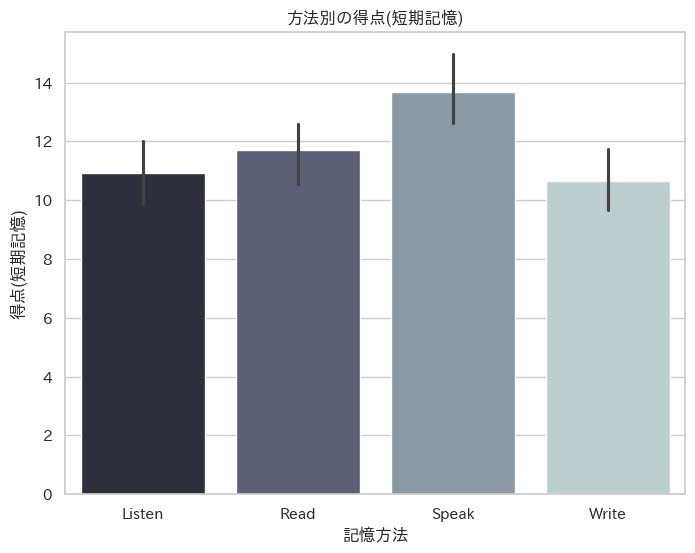

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.figure(figsize=(8, 6))

# 棒グラフ (平均値) を描画
# デフォルトの95%信頼区間エラーバーが描画
sns.barplot(
    data=df_final_long,
    x='Method',
    y='ShortTerm',
    palette='bone'
)

plt.title('方法別の得点(短期記憶)')
plt.xlabel('記憶方法')
plt.ylabel('得点(短期記憶)')
plt.show()

### ***長期記憶***

問い: 「48時間後（長期記憶）において、4つの記憶方法（Method）の間に得点の差はあるか？」


わかること: どの方法が「記憶の定着（長期保持）」に最も強いかがわかる。

In [16]:
# 分析2: LongTerm
# ---------------------------------

# AnovaRMを実行
aov_long = AnovaRM(
    data=df_final_long,
    depvar='LongTerm',          # 従属変数
    subject='Participant_ID',   # 被験者ID
    within=['Method']
)

# 結果のサマリーを表示
fit_long = aov_long.fit()
print(fit_long.summary())

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
Method 11.6186 3.0000 87.0000 0.0000



/tmp/ipython-input-1027115188.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


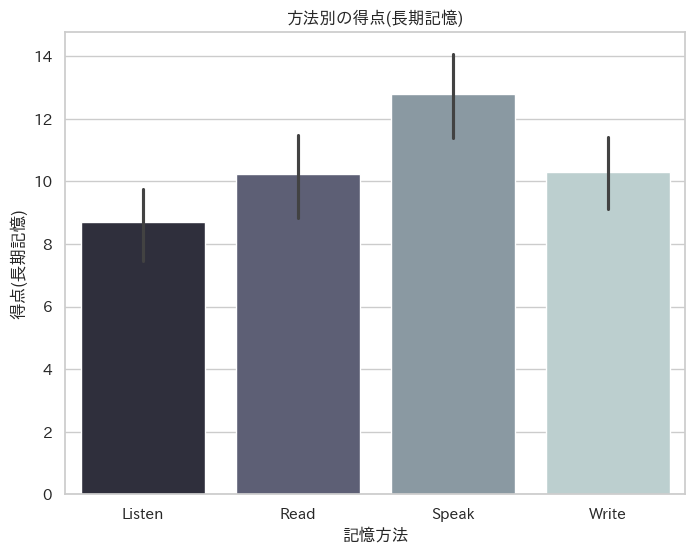

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# 棒グラフ (平均値) を描画
# デフォルトの95%信頼区間エラーバーが描画
sns.barplot(
    data=df_final_long,
    x='Method',
    y='LongTerm',
    palette='bone'
)

plt.title('方法別の得点(長期記憶)')
plt.xlabel('記憶方法')
plt.ylabel('得点(長期記憶)')
plt.show()

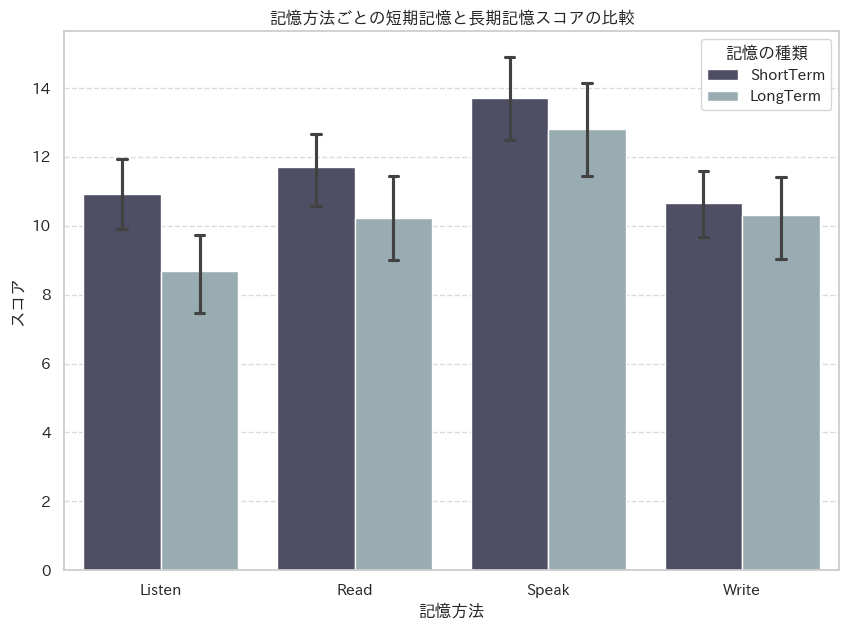

In [40]:
# ShortTermとLongTermのデータだけを抽出してmeltする
df_melted = df_final_long.melt(
    id_vars=['Participant_ID', 'WMC', 'Method'],
    value_vars=['ShortTerm', 'LongTerm'],
    var_name='MemoryType', # 'ShortTerm'または'LongTerm'が入る
    value_name='Score'      # 実際のスコアが入る
)

plt.figure(figsize=(10, 7))
sns.barplot(
    data=df_melted,
    x='Method',
    y='Score',
    hue='MemoryType', # MemoryTypeで棒を分ける
    palette='bone', # カラーパレットの指定
    capsize=0.1 # エラーバーのキャップサイズ
)

plt.title('記憶方法ごとの短期記憶と長期記憶スコアの比較')
plt.xlabel('記憶方法')
plt.ylabel('スコア')
plt.legend(title='記憶の種類')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### ***負荷***

In [18]:
# 分析3: 負荷
# ---------------------------------

# AnovaRMを実行
aov_long = AnovaRM(
    data=df_final_long,
    depvar='Load',          # 従属変数
    subject='Participant_ID',   # 被験者ID
    within=['Method']
)

# 結果のサマリーを表示
fit_long = aov_long.fit()
print(fit_long.summary())

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
Method 35.6818 3.0000 87.0000 0.0000



/tmp/ipython-input-605073953.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


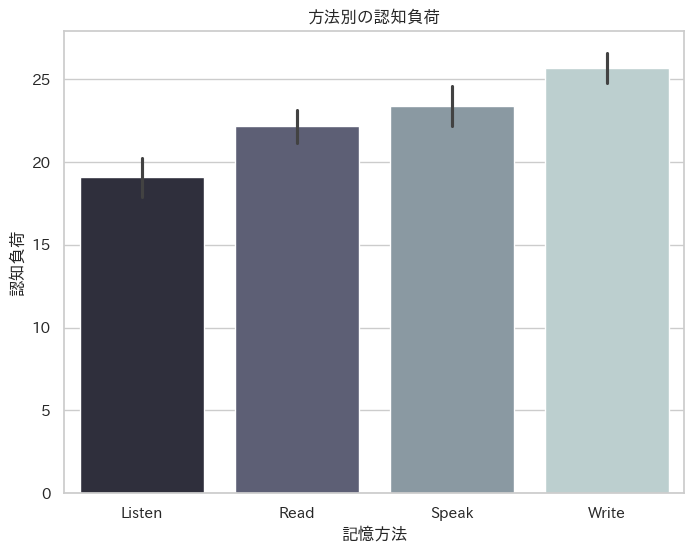

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))

# 棒グラフ (平均値) を描画
# デフォルトの95%信頼区間エラーバーが描画
sns.barplot(
    data=df_final_long,
    x='Method',
    y='Load',
    palette='bone'
)

plt.title('方法別の認知負荷')
plt.xlabel('記憶方法')
plt.ylabel('認知負荷')
plt.show()

## ***多重比較***

長期記憶では有意差が見られなかったため、短期記憶でのみ行う。

In [20]:
!pip install pingouin

In [21]:
import pingouin as pg

# ----------------------------------
# 分析1: ShortTerm の多重比較
# (LongTermは ANOVAで有意差がなかったため、行わない)
# ----------------------------------

# pg.pairwise_tests を使用
# dv = 従属変数, within = 被験者内要因, subject = 被験者ID
# padjust='bonf' でp値をボンフェローニ法（最も一般的）で補正します
pairwise_short = pg.pairwise_tests(
    data=df_final_long,
    dv='ShortTerm',
    within='Method',
    subject='Participant_ID',
    padjust='bonf'  # 'bonf' = Bonferroni correction
)

# 結果の表示
# 'p-corr' (補正済みp値) が 0.05 を下回っているペアを探します
print(pairwise_short.to_markdown(index=False, numalign="left", stralign="left"))

| Contrast   | A      | B     | Paired   | Parametric   | T        | dof   | alternative   | p-unc       | p-corr      | p-adjust   | BF10    | hedges    |
|:-----------|:-------|:------|:---------|:-------------|:---------|:------|:--------------|:------------|:------------|:-----------|:--------|:----------|
| Method     | Listen | Read  | True     | True         | -1.62621 | 29    | two-sided     | 0.114725    | 0.688352    | bonf       | 0.63    | -0.257683 |
| Method     | Listen | Speak | True     | True         | -4.71644 | 29    | two-sided     | 5.5758e-05  | 0.000334548 | bonf       | 440.414 | -0.872481 |
| Method     | Listen | Write | True     | True         | 0.503677 | 29    | two-sided     | 0.618293    | 1           | bonf       | 0.219   | 0.0926052 |
| Method     | Read   | Speak | True     | True         | -3.82385 | 29    | two-sided     | 0.000644033 | 0.0038642   | bonf       | 48.914  | -0.632698 |
| Method     | Read   | Write | True     | True         | 1.9239

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Write vs. Speak: Custom statistical test, P_val:1.020e-07
Read vs. Speak: Custom statistical test, P_val:3.900e-03
Listen vs. Speak: Custom statistical test, P_val:3.000e-04


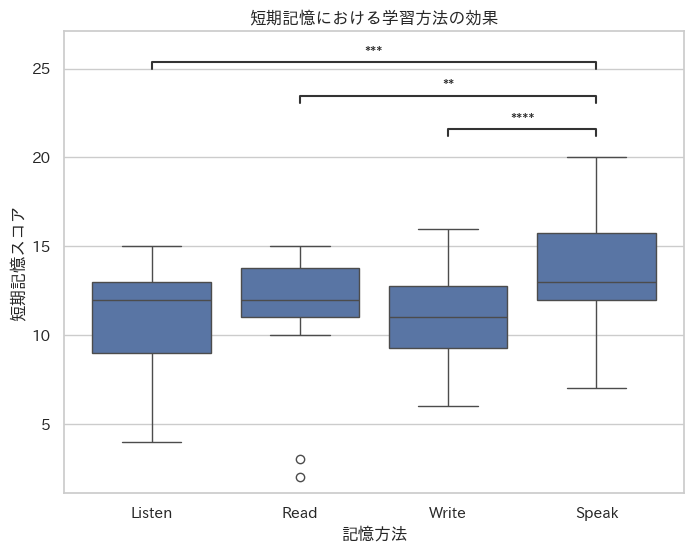

In [22]:
from statannotations.Annotator import Annotator

# プロットの作成
plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=df_final_long, x='Method', y='ShortTerm', order=['Listen', 'Read', 'Write', 'Speak'])

# 比較したいペア（有意差が出たものだけ指定するとスッキリします）
pairs = [("Speak", "Listen"), ("Speak", "Read"), ("Speak", "Write")]

# Annotatorの設定
annotator = Annotator(ax, pairs, data=df_final_long, x='Method', y='ShortTerm', order=['Listen', 'Read', 'Write', 'Speak'])
annotator.configure(test=None, text_format='star', loc='inside') # text_format='star' で * 表示
annotator.set_pvalues([0.0003, 0.0039, 1.02e-07]) # ここに先ほどの p-corr を入力

annotator.annotate()

plt.title("短期記憶における学習方法の効果")
plt.xlabel('記憶方法')
plt.ylabel('短期記憶スコア')
plt.show()

有意となったペアに鉤括弧をつけている。

## ***相関分析***

### ***「努力 vs 結果」の相関（負荷とスコア）***

「大変な（負荷が高い）勉強法ほど、本当に記憶に定着するのか？」を検証


見るべきペア: Load と LongTerm

問い: 「主観的認知負荷（Load）と、長期記憶スコア（LongTerm）の間に関係はあるか？」

In [23]:
from scipy.stats import pearsonr
import numpy as np

print("--- 相関分析1: 認知負荷(Load) vs 長期記憶(LongTerm) ---")

# 1. Method(方法) ごとに Load と LongTerm の平均値を計算
df_method_means = df_final_long.groupby('Method')[['Load', 'LongTerm']].mean()

print("\n[方法ごとの平均値]")
print(df_method_means.to_markdown(numalign="left", stralign="left"))

# 2. ピアソンの相関分析を実行
#    (Loadの平均値 vs LongTermの平均値)
correlation, p_value = pearsonr(df_method_means['Load'], df_method_means['LongTerm'])

print(f"\n[相関の結果]")
print(f"  相関係数 (r): {correlation:.4f}")
print(f"  p値 (p-value): {p_value:.4f}")

--- 相関分析1: 認知負荷(Load) vs 長期記憶(LongTerm) ---

[方法ごとの平均値]
| Method   | Load    | LongTerm   |
|:---------|:--------|:-----------|
| Listen   | 19.0667 | 8.7        |
| Read     | 22.1667 | 10.2333    |
| Speak    | 23.4    | 12.8       |
| Write    | 25.7    | 10.3       |

[相関の結果]
  相関係数 (r): 0.5469
  p値 (p-value): 0.4531


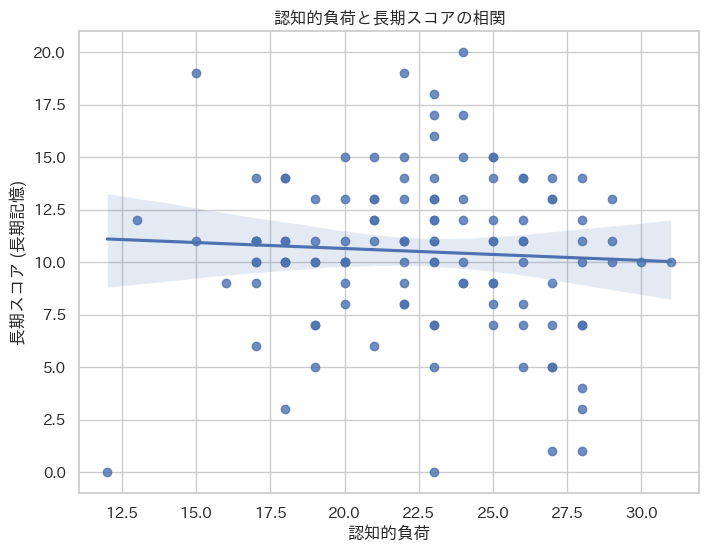

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# グラフのスタイルとサイズを指定
# sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))

# regplot を使用
# data: 全体の縦長データ (N=120)
# x: 認知負荷
# y: 長期記憶スコア
sns.regplot(
    data=df_final_long,
    x='Load',
    y='LongTerm'
)

plt.title('認知的負荷と長期スコアの相関')
plt.xlabel('認知的負荷')
plt.ylabel('長期スコア (長期記憶)')
plt.show()

| 手法 | 認知負荷 (Load) | 長期記憶 (Score) | 特徴（コスト対効果） |
| :--- | :--- | :--- | :--- |
| **Listen** | 19.1 (低) | 8.7 (低) | 楽だが覚えない |
| **Read** | 22.2 (中) | 10.2 (中) | 普通 |
| **Speak** | 23.4 (中) | 12.8 (最高) | 負荷はそこそこで、一番覚える（高効率） |
| **Write** | 25.7 (最高) | 10.3 (中) | 一番疲れるのに、Readと同程度しか覚えない（低効率） |

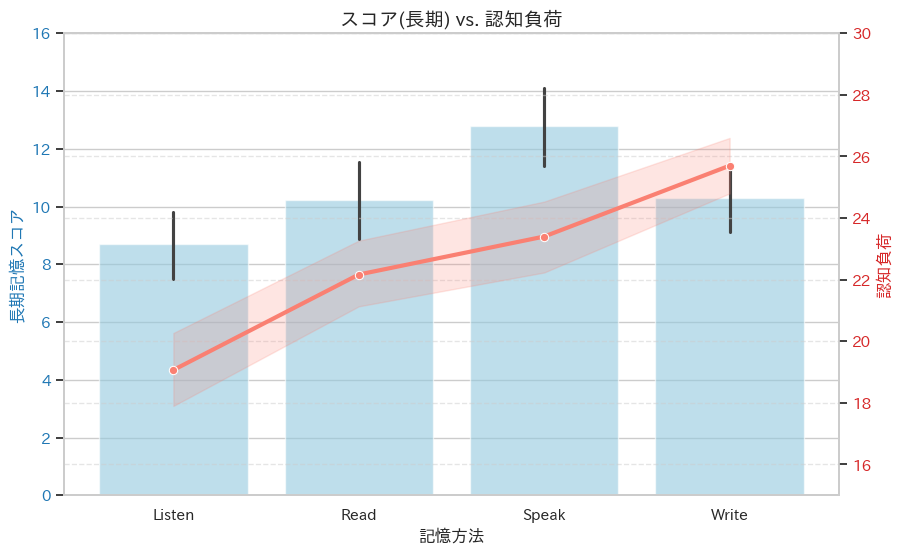

In [25]:
# プロットの作成
fig, ax1 = plt.subplots(figsize=(10, 6))

# カラー設定
color_bar = 'skyblue'
color_line = 'salmon'

# 第1軸（左側）：長期記憶スコア（棒グラフ）
# 成果を表すので、土台となる棒グラフにします
sns.barplot(data=df_final_long, x='Method', y='LongTerm', color=color_bar, ax=ax1, alpha=0.6)
ax1.set_ylabel('長期記憶スコア', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xlabel('記憶方法', fontsize=12)
ax1.set_ylim(0, 16)  # グラフのバランス調整

# 第2軸（右側）：認知負荷（折れ線グラフ）
# コストの推移を表すので、上を走る折れ線にします
ax2 = ax1.twinx()
sns.lineplot(data=df_final_long, x='Method', y='Load', color=color_line, marker='o', linewidth=3, ax=ax2, sort=False)
ax2.set_ylabel('認知負荷', color='tab:red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(15, 30)  # 変動が見えやすいように範囲調整

plt.title('スコア(長期) vs. 認知負荷', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

書くのコスパの悪さがわかる。

### ***「個人の地力 vs 結果」の相関（WMCと長期スコア）***

In [26]:
print("--- 相関分析2: WMC vs 長期記憶(LongTerm) ---")

# 1. Participant_ID(被験者) ごとに WMC と LongTerm の平均値を計算
#    (WMCは被験者ごとで一定なので、mean()でもfirst()でも同じ値になる)
df_participant_means = df_final_long.groupby('Participant_ID')[['WMC', 'LongTerm']].mean()

# print("\n[被験者ごとの平均値 (先頭5名)]")
# print(df_participant_means.head().to_markdown(numalign="left", stralign="left"))

# 2. ピアソンの相関分析を実行
#    (WMC vs LongTermの平均値)
correlation, p_value = pearsonr(df_participant_means['WMC'], df_participant_means['LongTerm'])

print(f"\n[相関の結果]")
print(f"  相関係数 (r): {correlation:.4f}")
print(f"  p値 (p-value): {p_value:.4f}")

--- 相関分析2: WMC vs 長期記憶(LongTerm) ---

[相関の結果]
  相関係数 (r): 0.5427
  p値 (p-value): 0.0019


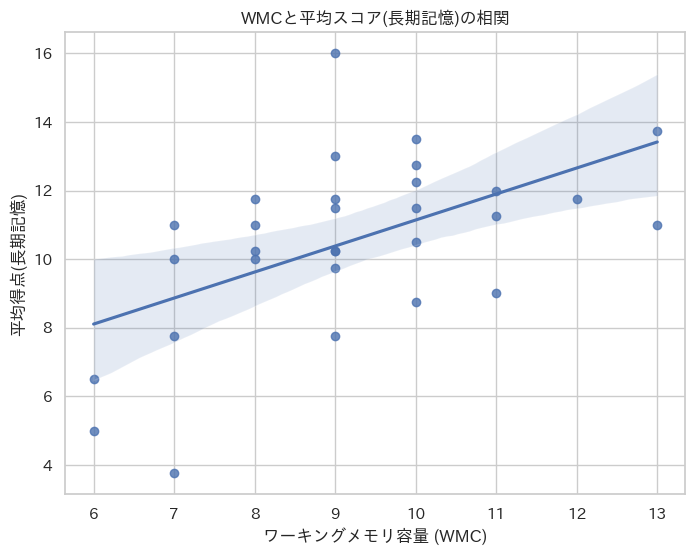

In [27]:
# まず、被験者ごとの平均値データ (N=30) を再作成します
df_participant_means = df_final_long.groupby('Participant_ID')[['WMC', 'LongTerm']].mean()

# グラフのスタイルとサイズを指定
plt.figure(figsize=(8, 6))

# regplot を使用
# data: 被験者ごとの平均データ (N=30)
# x: WMC
# y: 長期記憶スコアの平均値
sns.regplot(
    data=df_participant_means,
    x='WMC',
    y='LongTerm'
)

plt.title('WMCと平均スコア(長期記憶)の相関')
plt.xlabel('ワーキングメモリ容量 (WMC)')
plt.ylabel('平均得点(長期記憶)')
plt.show()

有意差がある。

## ***重回帰分析***

| 要因 | 短期記憶 (Model 1) | 長期記憶 (Model 2) | 変化の解釈 |
| :--- | :--- | :--- | :--- |
| **Speak**の効果 | +3.26 ($p<.001$) | +4.32 ($p<.001$) | 時間経過により、**優位性がさらに拡大**した。 |
| **Write**の効果 | +0.49 (有意差なし) | +1.93 (有意傾向 $p=.055$) | 時間が経つと少し効果が出るが、それでも有意水準には届かない（**効率が悪い**）。 |
| **WMC**の効果 | +0.66 ($p<.001$) | +0.71 ($p<.001$) | 短期・長期問わず、**常に安定して成績を支えている**。 |
| **Load**の影響 | 負の傾向 (有意差なし) | 無関係 (有意差なし) | 苦労（負荷）は、直後も48時間後も、**成績には寄与しない**。 |

### ***短期記憶モデル***

$$ShortTerm\_Score \approx \alpha_0 + \alpha_1(WMC) + \alpha_2(Load) + \alpha_3(Method)$$

これが解明する問い:「そもそも、"学習直後"の成績（短期記憶）は何によって決まるのか？」

In [28]:
import statsmodels.formula.api as smf

print("--- モデル1: ShortTerm ~ WMC + Load + C(Method) ---")

# 1. モデルの式を定義
#    Y ~ X1 + X2 + C(X3)
#    C(Method) は、Methodをカテゴリ変数として扱う（ダミー変数化）指示
formula_short = "ShortTerm ~ WMC + Load + C(Method)"

# 2. 混合効果モデル (MixedLM) を作成
#    groups=... で「参加者ごとのクセ」を考慮する
model_short = smf.mixedlm(
    formula=formula_short,
    data=df_final_long,
    groups=df_final_long["Participant_ID"]
)

# 3. モデルの学習（推定）を実行
results_short = model_short.fit()

# 4. 結果のサマリーを表示
print(results_short.summary())

--- モデル1: ShortTerm ~ WMC + Load + C(Method) ---
            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   ShortTerm
No. Observations:   120       Method:               REML     
No. Groups:         30        Scale:                3.8759   
Min. group size:    4         Log-Likelihood:       -272.2118
Max. group size:    4         Converged:            Yes      
Mean group size:    4.0                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           7.057    2.971  2.375 0.018  1.234 12.880
C(Method)[T.Read]   1.118    0.565  1.978 0.048  0.010  2.226
C(Method)[T.Speak]  3.258    0.615  5.300 0.000  2.053  4.463
C(Method)[T.Write]  0.486    0.734  0.662 0.508 -0.953  1.924
WMC                 0.659    0.221  2.980 0.003  0.226  1.092
Load               -0.113    0.08

listenとの比較の結果である。

* Speak: 圧倒的に強い（Listenより+3.3点）有意

* Read: まあまあ強い（Listenより+1.1点）ギリ有意

* Write: Listenと変わらない。有意でない

* WMC: 基礎体力として重要（+0.66点/単位）有意

* Load: 関係ない。有意でない

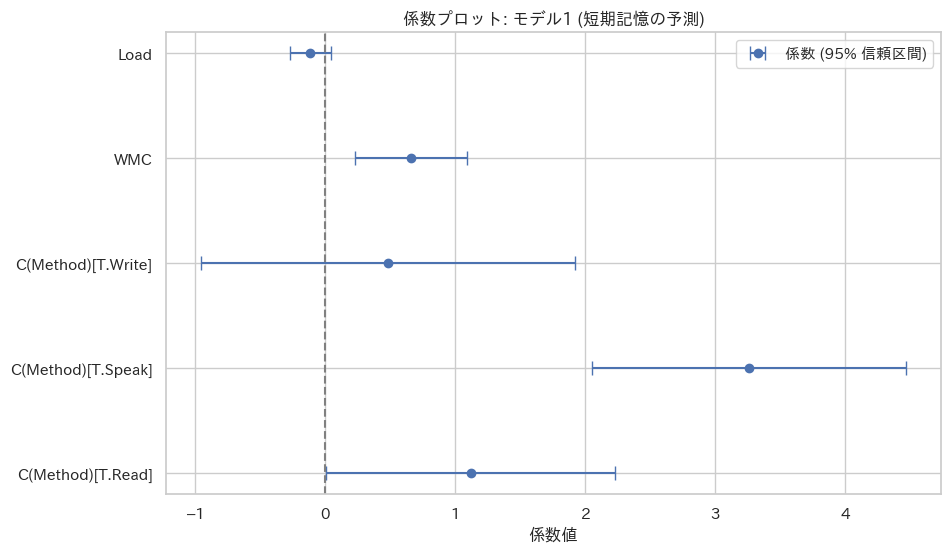

In [29]:
# --- 1. モデル結果からサマリーテーブルをDataFrameとして取得 ---
# results_short.summary().tables[1] が係数のテーブル
results_df = results_short.summary().tables[1]

# インデックスをリセットして、変数名を 'Variable' という列にする
results_df = results_df.reset_index()
results_df = results_df.rename(columns={'index': 'Variable'})

# 列名を整理
results_df = results_df.rename(columns={
    'P>|z|': 'P',
    '[0.025': 'Lower_CI',
    '0.975]': 'Upper_CI'
})

# 'Intercept'（切片）と 'Group Var' を除外
results_df = results_df[~results_df['Variable'].isin(['Intercept', 'Group Var'])]

# 数値列をfloatに変換
results_df[['Coef.', 'Lower_CI', 'Upper_CI', 'P']] = results_df[['Coef.', 'Lower_CI', 'Upper_CI', 'P']].astype(float)

# --- 2. グラフの描画 ---
plt.figure(figsize=(10, 6))

# 変数のリスト（Y軸）
y_pos = np.arange(len(results_df['Variable']))
# 係数の値（点）
x_vals = results_df['Coef.']
# エラーバー（95%信頼区間）
# Lower_CI と Upper_CI の差分として計算
x_err_lower = results_df['Coef.'] - results_df['Lower_CI']
x_err_upper = results_df['Upper_CI'] - results_df['Coef.']
x_err = [x_err_lower, x_err_upper]

plt.errorbar(
    x_vals,
    y_pos,
    xerr=x_err,
    fmt='o',  # 'o' = 点
    capsize=5, # エラーバーの「傘」のサイズ
    linestyle='None', # 点同士を結ぶ線はなし
    label='係数 (95% 信頼区間)'
)

# ゼロの垂直線
plt.axvline(x=0, color='grey', linestyle='--')

# グラフの体裁
plt.yticks(y_pos, results_df['Variable']) # Y軸に変数名
plt.xlabel('係数値')
plt.title('係数プロット: モデル1 (短期記憶の予測)')
plt.legend()
plt.show()

### ***長期記憶モデル***

$$LongTerm\_Score \approx \beta_0 + \beta_1(WMC) + \beta_2(Load) + \beta_3(Method)$$

これが解明する問い: 「48時間後の"記憶の定着"に、どの要因が最も効いているのか？」

In [30]:
print("--- モデル2: LongTerm ~ WMC + Load + C(Method) ---")

# 1. モデルの式を定義
formula_long = "LongTerm ~ WMC + Load + C(Method)"

# 2. 混合効果モデル (MixedLM) を作成
model_long = smf.mixedlm(
    formula=formula_long,
    data=df_final_long,
    groups=df_final_long["Participant_ID"]
)

# 3. モデルの学習（推定）を実行
results_long = model_long.fit()

# 4. 結果のサマリーを表示
print(results_long.summary())

--- モデル2: LongTerm ~ WMC + Load + C(Method) ---
            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   LongTerm 
No. Observations:   120       Method:               REML     
No. Groups:         30        Scale:                7.5041   
Min. group size:    4         Log-Likelihood:       -302.6178
Max. group size:    4         Converged:            Yes      
Mean group size:    4.0                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           3.148    3.694  0.852 0.394 -4.093 10.388
C(Method)[T.Read]   1.688    0.783  2.158 0.031  0.155  3.222
C(Method)[T.Speak]  4.317    0.848  5.089 0.000  2.654  5.979
C(Method)[T.Write]  1.932    1.007  1.919 0.055 -0.042  3.905
WMC                 0.710    0.246  2.888 0.004  0.228  1.191
Load               -0.050    0.108

「48時間経っても『Speak（話す）』の優位性は揺るがず、むしろ他の手法との差を広げている。一方で、『Write（書く）』は労力の割に報われない。」

### ***改善版モデル(長期記憶の予測)***

$$LongTerm\_Score \approx \beta_0 + \beta_1(WMC) + \beta_2(Load) + \beta_3(Method) + \beta_4(ShortTerm\_Score)$$

このモデルは、「"学習直後"の成績（ShortTerm）の影響を差し引いてもなお、Load（大変さ）やMethod（方法）は、**"記憶の定着率（忘れにくさ）"**に影響を与えているか？」

→　ShortTerm（直後の成績）を説明変数に入れたことで、「一度頭に入った知識が、どれだけ抜け落ちにくいか（定着率）」 を見

In [31]:
print("--- 改善版モデル2: LongTerm ~ ShortTerm + WMC + Load + C(Method) ---")

# 1. モデルの式を定義
#    ShortTerm を予測要因（説明変数）として追加
formula_long_improved = "LongTerm ~ ShortTerm + WMC + Load + C(Method)"

# 2. 混合効果モデル (MixedLM) を作成
model_long_improved = smf.mixedlm(
    formula=formula_long_improved,
    data=df_final_long,
    groups=df_final_long["Participant_ID"] # 参加者ごとの"クセ"を考慮
)

# 3. モデルの学習（推定）を実行
results_long_improved = model_long_improved.fit()

# 4. 結果のサマリーを表示
print(results_long_improved.summary())

--- 改善版モデル2: LongTerm ~ ShortTerm + WMC + Load + C(Method) ---


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   LongTerm 
No. Observations:   120       Method:               REML     
No. Groups:         30        Scale:                2.4858   
Min. group size:    4         Log-Likelihood:       -229.5973
Max. group size:    4         Converged:            Yes      
Mean group size:    4.0                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          -4.348    1.865 -2.331 0.020 -8.004 -0.692
C(Method)[T.Read]   0.501    0.450  1.115 0.265 -0.380  1.383
C(Method)[T.Speak]  0.859    0.516  1.666 0.096 -0.152  1.871
C(Method)[T.Write]  1.415    0.559  2.530 0.011  0.319  2.510
ShortTerm           1.061    0.059 18.071 0.000  0.946  1.176
WMC                 0.011    0.108  0.105 0.916 -0.201  0.224
Load                

| 手法 | 短期成績 (記銘力) | 長期定着 (保持力) | 特徴・キャッチコピー |
| :--- | :--- | :--- | :--- |
| **Speak (話す)** | ◎ (最強) | △ (普通) | 「**ロケットスタート型**」<br><br>とにかく最初に入れる量がすごい。だから結果として後でも勝つ。 |
| **Write (書く)** | △ (普通) | ◎ (最強) | 「**スルメ型（大器晩成）**」<br><br>入れるのは大変だが、一度刻み込んだら絶対に忘れない。粘り強い。 |
| **Read (読む)** | ○ (そこそこ) | △ (普通) | 「**バランス型**」<br><br>特筆すべき強みも弱みもない。 |
| **Listen (聴く)** | 基準 | 基準 | 「**省エネ型**」<br><br>負荷も低いが、成果も低い。 |

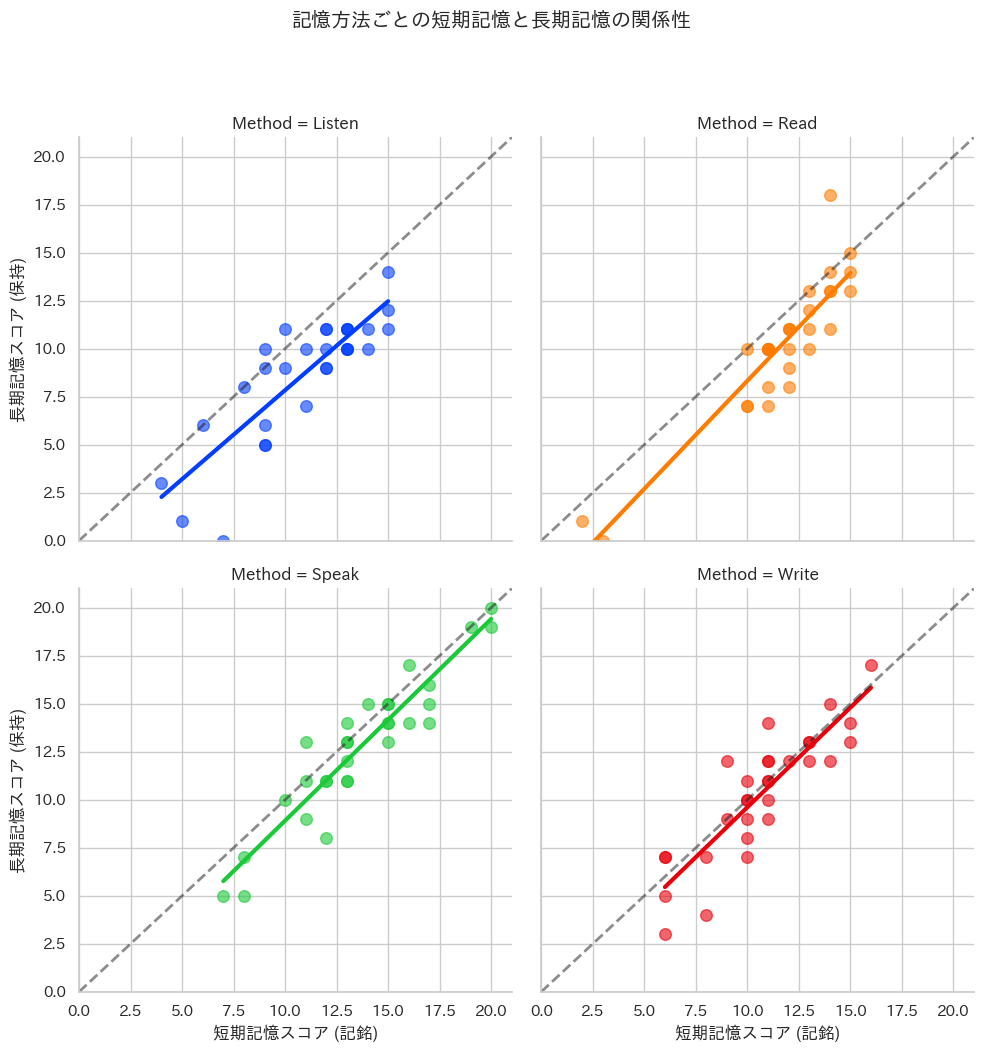

In [32]:
# カラーパレットを定義（視認性を高めるため少し濃い色に）
colors = sns.color_palette("bright", 4)
method_colors = dict(zip(['Listen', 'Read', 'Speak', 'Write'], colors))

# グラフの作成（col='Method' で分割します）
g = sns.lmplot(
    data=df_final_long,
    x='ShortTerm',
    y='LongTerm',
    hue='Method',    # 色分けも併用
    col='Method',    # 【重要】ここを変更：手法ごとに列を分ける
    col_wrap=2,      # 2列で折り返す（4つ横並びが良ければcol_wrap=4に）
    palette=method_colors,
    height=5,        # 1つあたりのグラフの高さ
    aspect=1,        # アスペクト比（正方形が見やすい）
    ci=None,         # 信頼区間は表示しない（スッキリさせるため）
    scatter_kws={'alpha': 0.6, 's': 70}, # 点の透明度と大きさ
    line_kws={'linewidth': 3} # 線の太さ
)

# 各サブプロットに「忘却ゼロライン（y=x）」を追加する処理
max_val = max(df_final_long['ShortTerm'].max(), df_final_long['LongTerm'].max()) + 1
for ax in g.axes.flat:
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=2, label='忘却ゼロライン (y=x)')
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)

# 全体のタイトルなどを調整
g.fig.suptitle('記憶方法ごとの短期記憶と長期記憶の関係性', y=1.05)
g.set_axis_labels("短期記憶スコア (記銘)", "長期記憶スコア (保持)")

plt.tight_layout()
plt.show()

記憶の保持率

$$RetentionRate = \frac{LongTerm}{ShortTerm} \times 100$$

/tmp/ipython-input-1964830226.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_final_long, x='Method', y='RetentionRate', capsize=.1, palette="bone", legend=False)


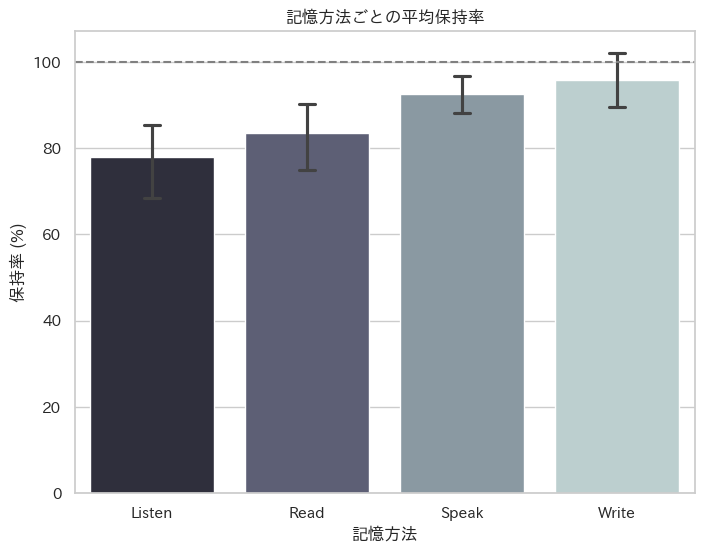

In [33]:
# 保持率の計算（0除算回避のためShortTermが0の場合は除外などの処理が必要ですが、今回は簡易的に）
df_final_long['RetentionRate'] = (df_final_long['LongTerm'] / df_final_long['ShortTerm']) * 100

# 棒グラフ
plt.figure(figsize=(8, 6))
sns.barplot(data=df_final_long, x='Method', y='RetentionRate', capsize=.1, palette="bone", legend=False)
plt.title("記憶方法ごとの平均保持率")
plt.ylabel("保持率 (%)")
plt.xlabel("記憶方法")
plt.axhline(100, color='gray', linestyle='--') # 100%ライン
plt.show()

# ***参考***

## ***WMCのグルーピング***

ここではWMCのスコアによって被験者を「高郡」「低郡」に分ける。

つまりWMCを２値で扱う。

In [34]:
# 1. WMCの中央値 (Median) を計算
wmc_median = df_final_long['WMC'].median()
print(f"WMCの中央値: {wmc_median}")

# 2. 中央値を使ってグループ分け (Median Split)
#    中央値「より大きい」 -> 'High' (高群)
#    中央値「以下」       -> 'Low'  (低群)
df_final_long['WMC_Group'] = np.where(df_final_long['WMC'] > wmc_median, 'High', 'Low')
display(df_final_long[['Participant_ID', 'WMC', 'WMC_Group', 'Method']])

# 4. 各グループの人数の確認
unique_participants = df_final_long[['Participant_ID', 'WMC_Group']].drop_duplicates()
group_counts = unique_participants['WMC_Group'].value_counts()

print("\n[グループごとの人数]")
print(group_counts.to_markdown(numalign="left", stralign="left"))

WMCの中央値: 9.0


,Participant_ID,WMC,WMC_Group,Method
0,P01,10,High,Listen
1,P01,10,High,Read
2,P01,10,High,Speak
3,P01,10,High,Write
4,P02,9,Low,Listen
...,...,...,...,...
115,P29,8,Low,Write
116,P30,9,Low,Listen
117,P30,9,Low,Read
118,P30,9,Low,Speak



[グループごとの人数]
| WMC_Group   | count   |
|:------------|:--------|
| Low         | 18      |
| High        | 12      |


--- 3-1. 記述統計: 各条件の平均値と標準偏差 ---
|                    | ('ShortTerm', 'mean')   | ('ShortTerm', 'std')   | ('LongTerm', 'mean')   | ('LongTerm', 'std')   | ('Load', 'mean')   | ('Load', 'std')   |
|:-------------------|:------------------------|:-----------------------|:-----------------------|:----------------------|:-------------------|:------------------|
| ('Listen', '低群') | 10.44                   | 3.09                   | 8.5                    | 2.98                  | 20.28              | 3.16              |
| ('Listen', '高群') | 11.67                   | 2.67                   | 9                      | 3.74                  | 17.25              | 3.19              |
| ('Read', '低群')   | 11.06                   | 3.51                   | 9.67                   | 4.33                  | 23.61              | 2.83              |
| ('Read', '高群')   | 12.67                   | 1.37                   | 11.08                  | 2.11                  | 20                 | 2.09        

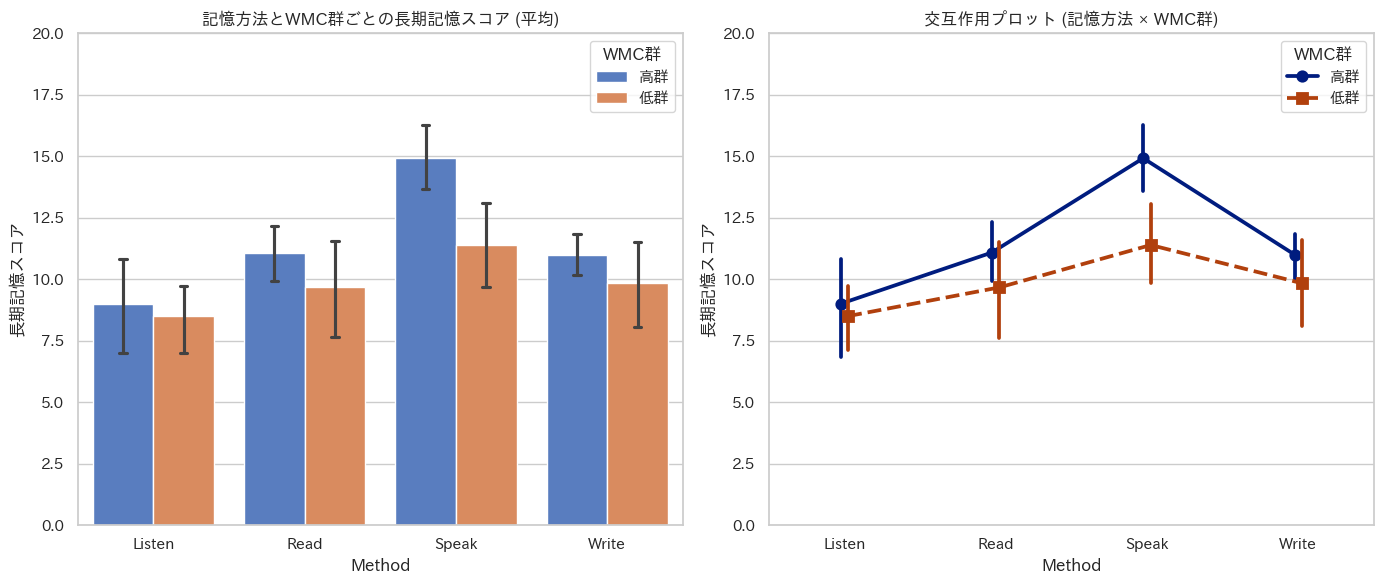

In [35]:
# Temporarily map 'High' and 'Low' to Japanese for plotting
df_final_long_jp_wmc = df_final_long.copy()
df_final_long_jp_wmc['WMC_Group'] = df_final_long_jp_wmc['WMC_Group'].map({'High': '高群', 'Low': '低群'})


# -------------------------------------------------------
# 3-1. 記述統計表の作成 (Table 1用)
# -------------------------------------------------------
print("--- 3-1. 記述統計: 各条件の平均値と標準偏差 ---")

# Method x WMC_Group ごとの平均値(mean)と標準偏差(std)を一括計算
# numeric_only=True で数値列だけを対象にする
desc_stats = df_final_long_jp_wmc.groupby(['Method', 'WMC_Group'])[['ShortTerm', 'LongTerm', 'Load']].agg(['mean', 'std'])

# 小数点以下2桁に丸めて表示
print(desc_stats.round(2).to_markdown(numalign="left", stralign="left"))


# -------------------------------------------------------
# 3-2. 可視化: 長期記憶 (LongTerm) の交互作用プロット ---
# -------------------------------------------------------
print("\n--- 3-2. 可視化: 長期記憶 (LongTerm) の交互作用プロット ---")

# 図の枠組みを作成 (1行2列でグラフを並べる)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- (左) 集合棒グラフ (Bar Chart) ---
# 直感的に「高さ」の違いを比較しやすい
sns.barplot(
    data=df_final_long_jp_wmc, # Use the mapped DataFrame
    x='Method',
    y='LongTerm',
    hue='WMC_Group',
    palette='muted',
    capsize=0.1,
    ax=axes[0] # 左側に描画
)
axes[0].set_title("記憶方法とWMC群ごとの長期記憶スコア (平均)")
axes[0].set_ylabel("長期記憶スコア")
axes[0].set_ylim(0, 20) # 縦軸の範囲を固定 (見やすくするため)
# Update legend title
axes[0].legend(title='WMC群')


# --- (右) 交互作用図 (Point/Line Plot) ---
# 線がクロスしているか（交互作用があるか）を確認しやすい
sns.pointplot(
    data=df_final_long_jp_wmc, # Use the mapped DataFrame
    x='Method',
    y='LongTerm',
    hue='WMC_Group',
    palette='dark',
    markers=["o", "s"],
    linestyles=["-", "--"],
    dodge=True,
    ax=axes[1] # 右側に描画
)
axes[1].set_title("交互作用プロット (記憶方法 × WMC群)")
axes[1].set_ylabel("長期記憶スコア")
axes[1].set_ylim(0, 20)
# Update legend title
axes[1].legend(title='WMC群')

plt.tight_layout()
plt.show()

### ***重回帰分析***

$$LongTerm \approx WMC\_Group \times Method + Load$$

In [36]:
import statsmodels.formula.api as smf

print("--- 重回帰分析 (混合効果モデル): WMC群 × 記憶方法 の交互作用 ---")

# 1. モデルの定義
#    LongTerm (長期記憶) を予測する
#    C(WMC_Group) * C(Method) : グループと方法の「組み合わせ効果」を見る
#    + Load : 「大変さ」の影響も考慮に入れておく (共変量)
formula_grouped = "LongTerm ~ C(WMC_Group) * C(Method) + Load"

# 2. モデルの作成 (混合効果モデル)
#    groups="Participant_ID" で、個人ごとのばらつきを考慮
model_grouped = smf.mixedlm(
    formula=formula_grouped,
    data=df_final_long,
    groups=df_final_long["Participant_ID"]
)

# 3. 分析の実行
results_grouped = model_grouped.fit()

# 4. 結果の表示
print(results_grouped.summary())

--- 重回帰分析 (混合効果モデル): WMC群 × 記憶方法 の交互作用 ---
                      Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         LongTerm 
No. Observations:           120             Method:                     REML     
No. Groups:                 30              Scale:                      7.3611   
Min. group size:            4               Log-Likelihood:             -298.1607
Max. group size:            4               Converged:                  Yes      
Mean group size:            4.0                                                  
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              11.079    2.097  5.284 0.000  6.969 15.188
C(WMC_Group)[T.Low]                    -0.135    1.291 -0.105 0.917 -2.666  2

## ***基本統計量の確認***

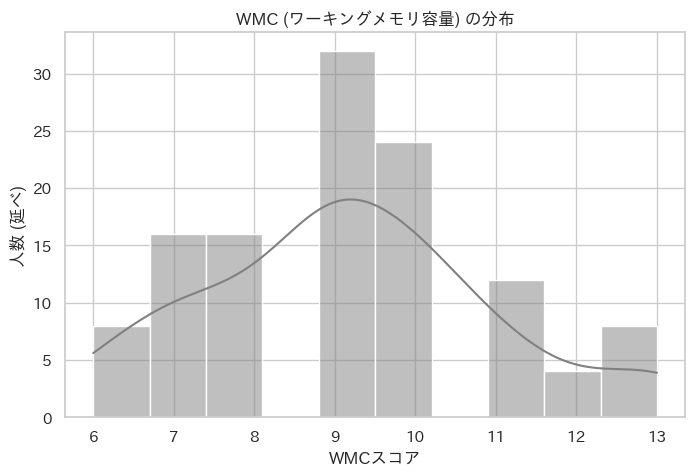

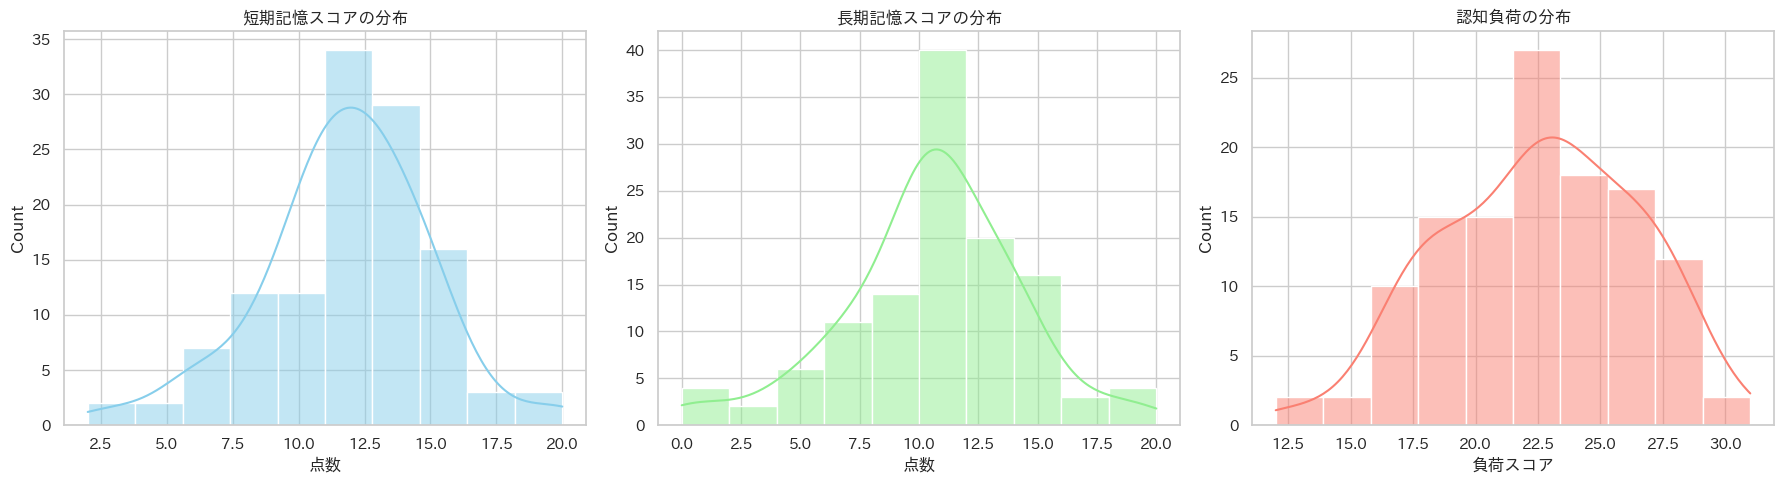

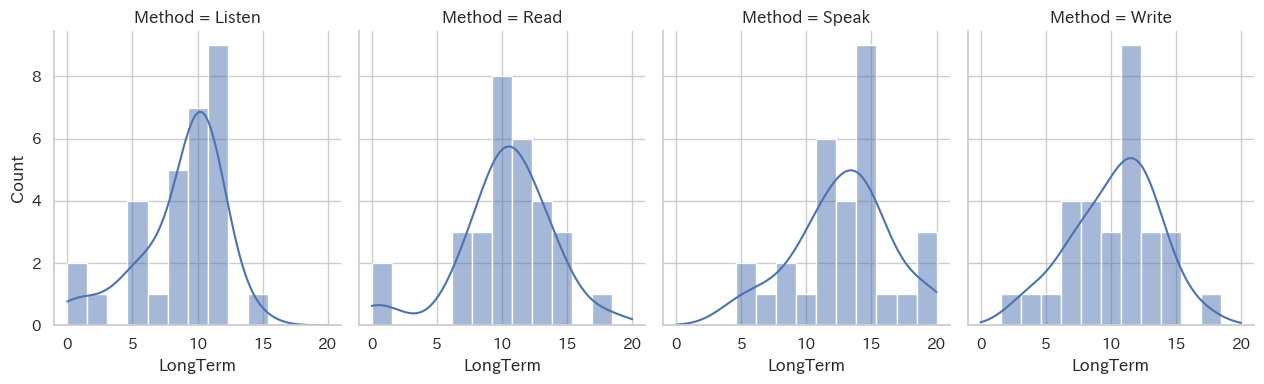

In [37]:
# 1. WMC (個人の記憶容量) の分布
# -------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.histplot(data=df_final_long, x='WMC', kde=True, bins=10, color='gray')
plt.title('WMC (ワーキングメモリ容量) の分布')
plt.xlabel('WMCスコア')
plt.ylabel('人数 (延べ)')
plt.show()

# 2. スコアと負荷の分布 (まとめて表示)
# -------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ShortTerm (短期記憶)
sns.histplot(data=df_final_long, x='ShortTerm', kde=True, bins=10, color='skyblue', ax=axes[0])
axes[0].set_title('短期記憶スコアの分布')
axes[0].set_xlabel('点数')

# LongTerm (長期記憶)
sns.histplot(data=df_final_long, x='LongTerm', kde=True, bins=10, color='lightgreen', ax=axes[1])
axes[1].set_title('長期記憶スコアの分布')
axes[1].set_xlabel('点数')

# Cognitive_Load (認知負荷)
sns.histplot(data=df_final_long, x='Load', kde=True, bins=10, color='salmon', ax=axes[2])
axes[2].set_title('認知負荷の分布')
axes[2].set_xlabel('負荷スコア')

plt.tight_layout()
plt.show()

# 3. (応用) 記憶方法ごとの分布の違いを見る
# -------------------------------------------------------
# 「書く」だけ分布が違うかも？などをチェック
sns.displot(
    data=df_final_long,
    x='LongTerm',
    col='Method', # 方法ごとにグラフを分ける
    kde=True,
    height=4,
    aspect=0.8
)
plt.show()